### Cardiovascular Disease Prediction

The goal of this project is to make 3 different classifier models on patient data about whether patients have heart disease or not based on 12 features. We will then compare each model's results to determine which one is the most effective at this task.

In [3]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, classification_report)

In [4]:
#load in dataset
df = pd.read_csv("Cardiovascular_Disease_Dataset.csv")
df.head(5)

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


### Investigating and Preprocessing the data

In [5]:
#dataset shape
df.shape

(1000, 14)

In [6]:
#view dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


In [7]:
#count the nulls
df.isnull().sum()

patientid            0
age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64

In [8]:
#descriptive stats
df.describe()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.048704e+06,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,2.895905e+06,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,1.033680e+05,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.536440e+06,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,4.952508e+06,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,7.681877e+06,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,9.990855e+06,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


In [9]:
#outlier detection for numeric columns
numeric_cols = ['age', 'restingBP', 'serumcholestrol',
                'maxheartrate', 'oldpeak']

outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    outlier_counts[col] = count

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
print(outlier_df)

                 Outlier Count
age                          0
restingBP                    0
serumcholestrol              0
maxheartrate                 0
oldpeak                      0


0 outliers were removed.

### Exploratory Data Analysis

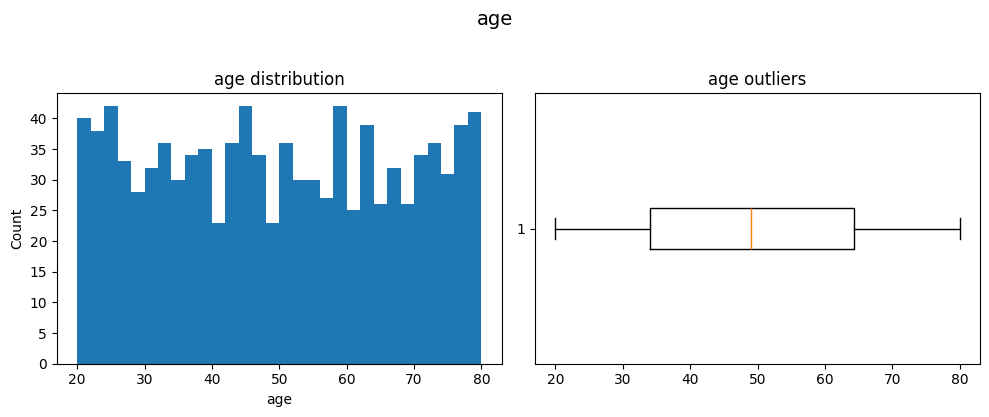

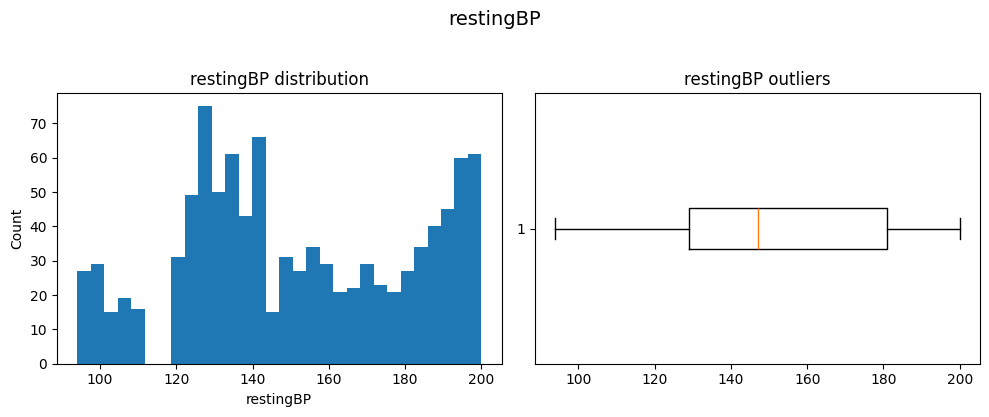

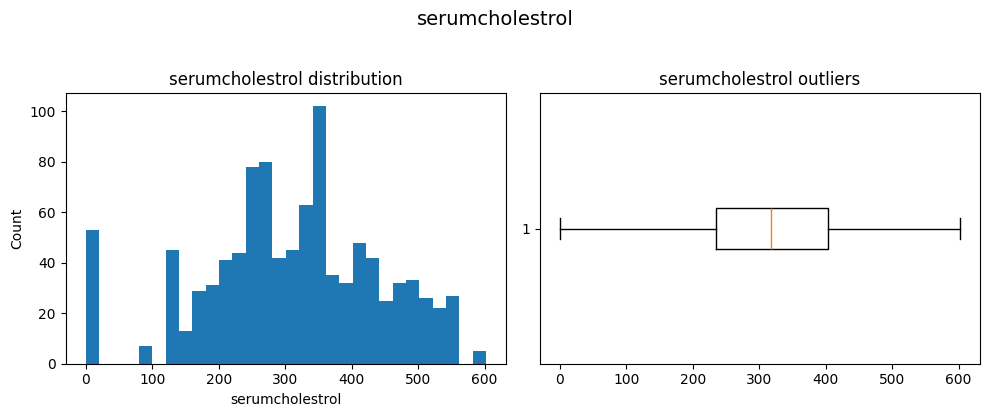

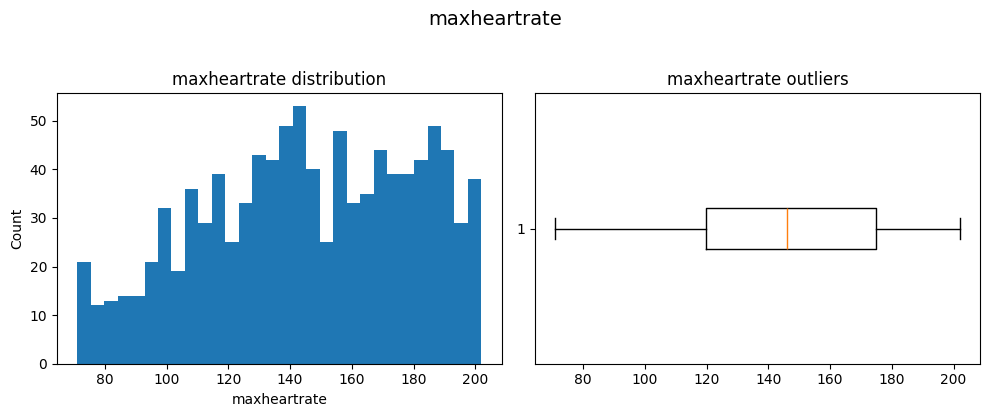

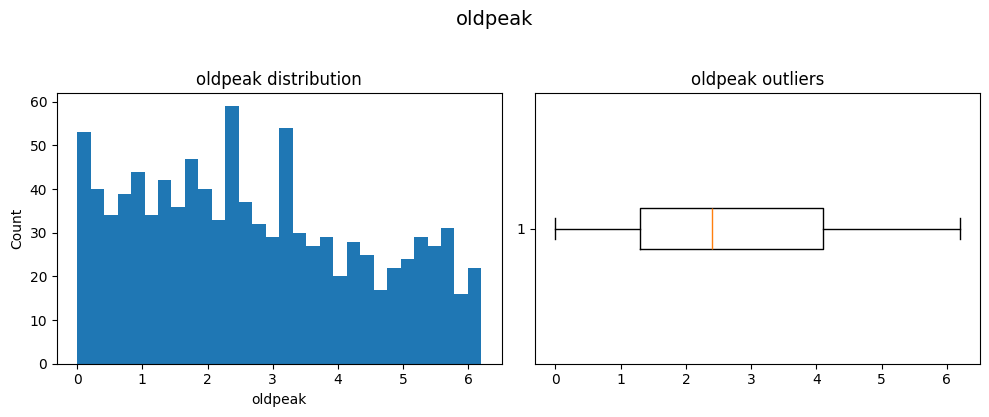

In [10]:

numeric_cols = ['age', 'restingBP', 'serumcholestrol', 
                'maxheartrate', 'oldpeak']

for col in numeric_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram
    ax1.hist(df[col], bins=30)
    ax1.set_title(f"{col} distribution")
    ax1.set_xlabel(col)
    ax1.set_ylabel("Count")
    
    # Boxplot
    ax2.boxplot(df[col], vert=False)
    ax2.set_title(f"{col} outliers")
    
    fig.suptitle(col, fontsize=14, y=1.03)
    fig.tight_layout()
    plt.show()


The initial EDA shows that  numeric features lie within clinically plausible ranges. 

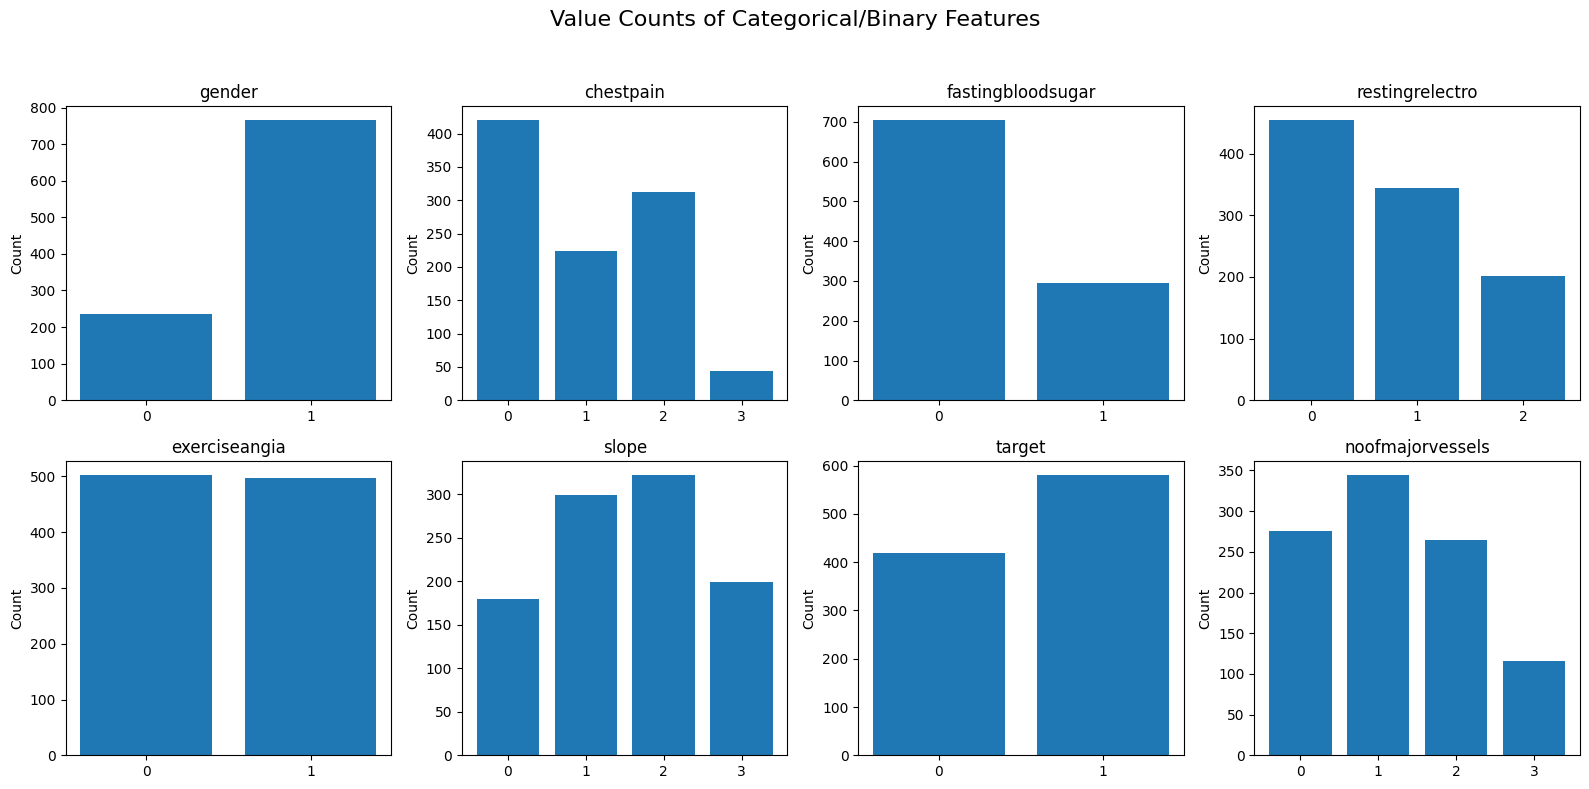

In [28]:
cat_cols = ['gender', 'chestpain', 'fastingbloodsugar',
            'restingrelectro', 'exerciseangia', 'slope', 'target', 'noofmajorvessels']


fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    counts = df[col].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title(col)
    ax.set_ylabel("Count")


fig.suptitle("Value Counts of Categorical/Binary Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


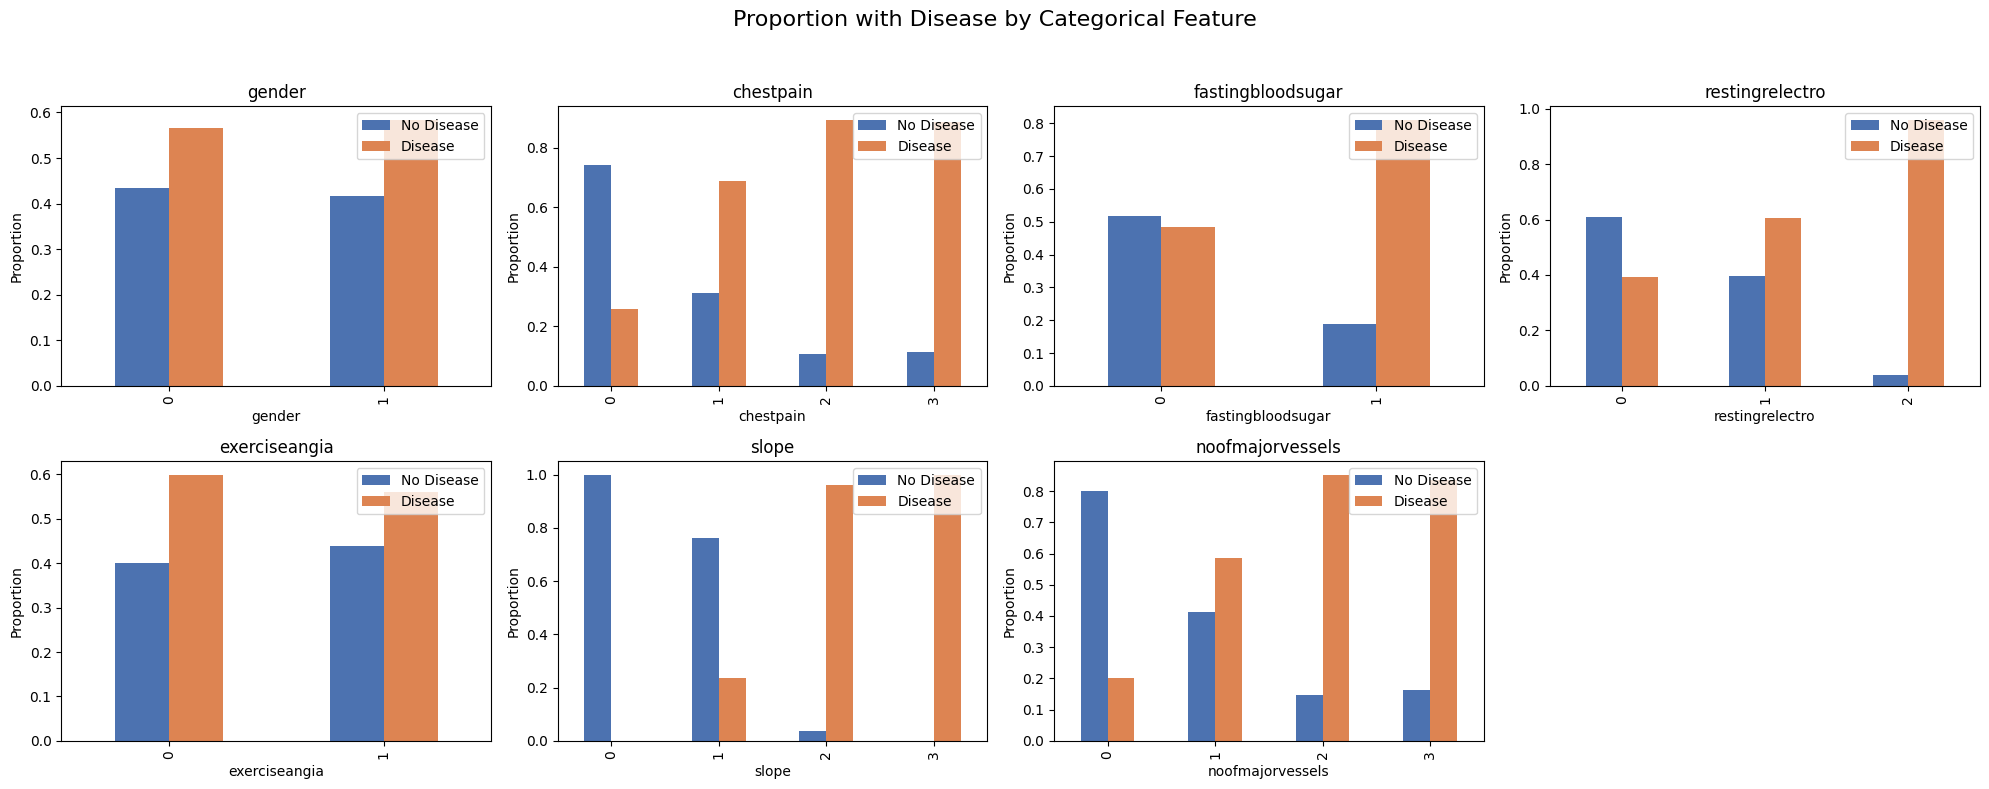

In [31]:
cat_cols = ['gender', 'chestpain', 'fastingbloodsugar',
            'restingrelectro', 'exerciseangia', 'slope', 'noofmajorvessels']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for ax, col in zip(axes, cat_cols):
    ct = pd.crosstab(df[col], df['target'], normalize='index')
    ct.plot(kind='bar', ax=ax, color=['#4c72b0','#dd8452'])
    ax.set_title(col)
    ax.set_ylabel('Proportion')
    ax.legend(['No Disease','Disease'], loc='upper right')

# 4) Turn off any unused axes
for ax in axes[len(cat_cols):]:
    ax.axis('off')

fig.suptitle("Proportion with Disease by Categorical Feature", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


From the proportion plots, can we see Chest pain type, ST‐segment slope, and the number of major vessels are the strongest categorical predictors. From our classification models, they will likely have one of the highest feature importance rate. Exercise‐induced angina and resting ECG abnormalities show moderate risk elevation. Gender and fasting blood sugar do not seem to hold too much weight in predicting heart disease.

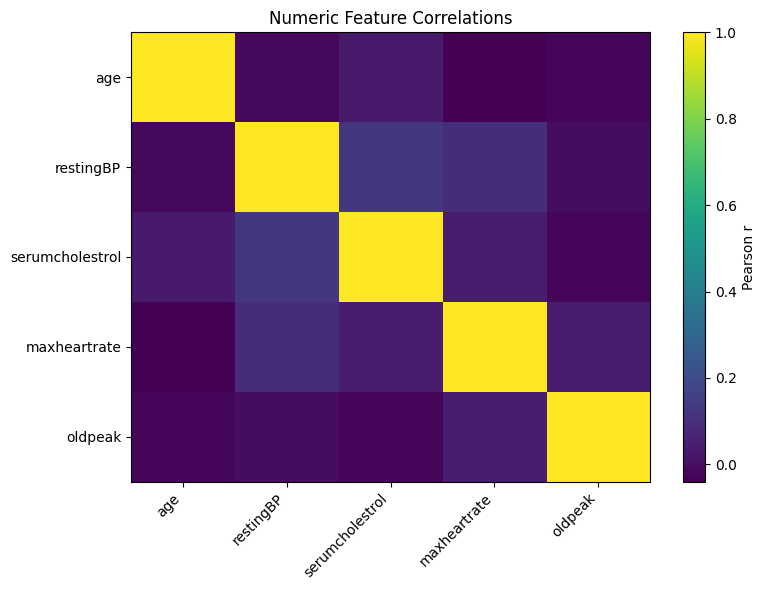

In [14]:
# 6) CORRELATION MATRIX – NUMERIC FEATURES
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='viridis', aspect='auto')
plt.colorbar(label="Pearson r")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Numeric Feature Correlations")
plt.tight_layout()
plt.show()

The correlation heatmap shows that all numeric features are only weakly correlated. This lack of multicollinearity is a good sign. It means each feature can contribute unique information, helping models learn more robust and stable patterns without one predictor drowning out another.

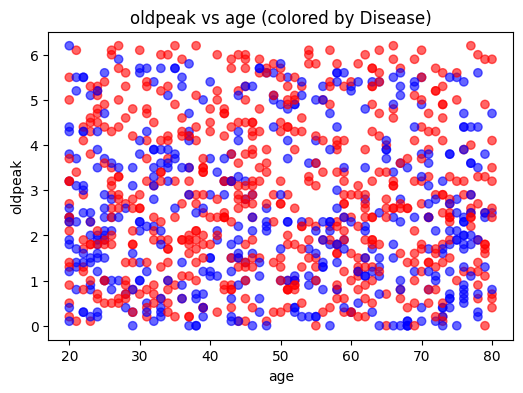

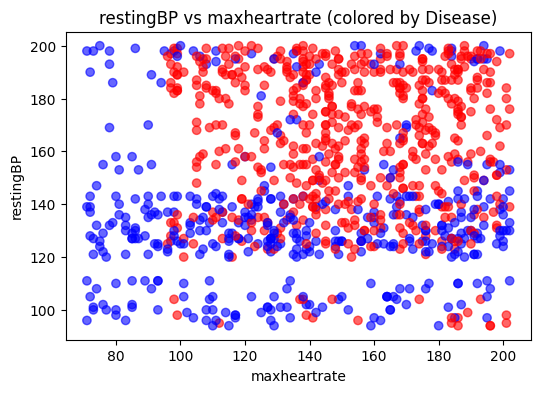

In [15]:
# 7) PAIRWISE SCATTERPLOTS FOR SELECTED PAIRS
pairs = [('age','oldpeak'), ('maxheartrate','restingBP')]
for x, y in pairs:
    plt.figure(figsize=(6,4))
    plt.scatter(df[x], df[y], c=df['target'], cmap='bwr', alpha=0.6)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"{y} vs {x} (colored by Disease)")
    plt.show()

The age vs. oldpeak plot shows red and blue points mixed across all ages and ST-depression levels, so neither alone strongly separates classes. In restingBP vs. maxheartrate, healthy patients are distributed everywhere, while diseased ones dominate high HR zone—highlighting having a lower maxheartrate could contribute to being disease free.

### Processing data for model training and evaluation

In [ ]:
sc = StandardScaler()
X_num = pd.DataFrame(
    sc.fit_transform(df[numeric_cols]),
    columns=numeric_cols,
    index=df.index
)

for cat in ['gender', 'chestpain', 'fastingbloodsugar',
            'restingrelectro', 'exerciseangia', 'slope']:
    X_num[cat] = df[cat]

X = X_num
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Training and Evaluating the Logistic Regression Model

In [ ]:
base_model = LogisticRegression(random_state=42, max_iter=5000)

param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.0, 0.5, 1.0] #only used when elastic net is penalty
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_lr = search.best_estimator_
print("Best Logistic Regression params:", search.best_params_)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Logistic Regression params: {'solver': 'saga', 'penalty': 'l1', 'l1_ratio': 0.5, 'C': np.float64(1.623776739188721)}


c:\Users\User\OneDrive\Desktop\Python_Files\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [ ]:
#Evaluate on test set
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

coefs = pd.Series(best_lr.coef_[0], index=X.columns)
print("\nTop positive predictors:\n", coefs.sort_values(ascending=False).head())
print("\nTop negative predictors:\n", coefs.sort_values().head())
print("full accuracy score: ", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        84
           1       0.98      1.00      0.99       116

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Test ROC AUC: 0.998

Top positive predictors:
 slope              6.046132
gender             2.571090
restingrelectro    1.080066
chestpain          1.019434
restingBP          0.982530
dtype: float64

Top negative predictors:
 oldpeak           -1.663280
age               -0.065772
exerciseangia      0.000000
serumcholestrol    0.018094
maxheartrate       0.443007
dtype: float64
full accuracy score:  0.99


### Training and Evaluating the Random Forest Classifier Model

In [19]:


# 5) Build, tune, and fit model
base_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best hyperparameters:", search.best_params_)




Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 30, 'class_weight': None}


In [ ]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

importances = pd.Series(best_model.feature_importances_, index=X.columns)
print("\nTop 5 Features:\n", importances.sort_values(ascending=False).head())


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98        84
           1       0.99      0.98      0.99       116

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200

Test ROC AUC: 0.998

Top 5 Features:
 slope              0.432147
chestpain          0.151803
restingBP          0.146082
serumcholestrol    0.075345
restingrelectro    0.049556
dtype: float64


### Training and Evaluating the XGB Classifier Model

In [21]:
# 5) Build, tune, and fit XGBoost model
base_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

best_xgb = search.best_estimator_
print("Best hyperparameters for XGBoost:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters for XGBoost: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


c:\Users\User\OneDrive\Desktop\Python_Files\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:59:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC: {:.3f}".format(roc_auc_score(y_test, y_proba)))

import pandas as pd
import numpy as np
importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
print("\nTop 5 Features:\n", importances.sort_values(ascending=False).head())


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.99      0.99      0.99       116

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

Test ROC AUC: 0.999

Top 5 Features:
 slope              0.590488
chestpain          0.162111
restingrelectro    0.066634
restingBP          0.042840
gender             0.034923
dtype: float32


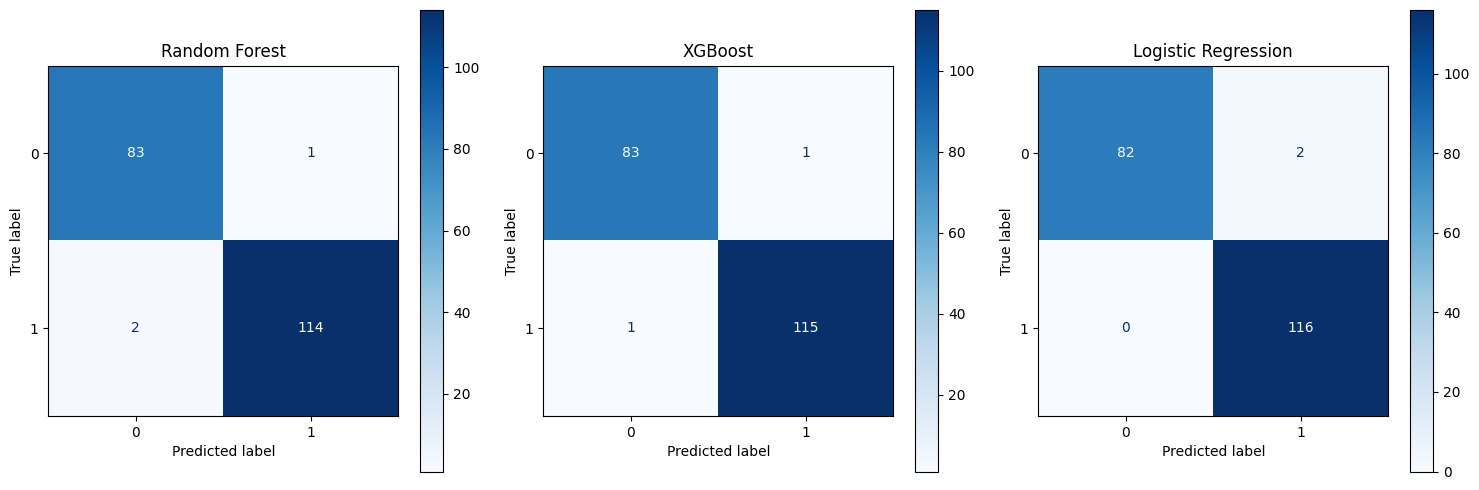

In [ ]:
models = {
    'Random Forest': best_model,
    'XGBoost': best_xgb,
    'Logistic Regression': best_lr
}

preds = {name: model.predict(X_test) for name, model in models.items()}
probas = {name: model.predict_proba(X_test)[:,1] for name, model in models.items()}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, (name, y_pred) in zip(axes, preds.items()):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, ax=ax, cmap='Blues', normalize=None
    )
    ax.set_title(name)
plt.tight_layout()
plt.show()


In [ ]:
rows = []
for name in models:
    y_pred = preds[name]
    y_proba = probas[name]
    rows.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

metrics_df = pd.DataFrame(rows).set_index('Model')

print(metrics_df.to_markdown(floatfmt=".5f"))


| Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:--------------------|-----------:|------------:|---------:|-----------:|----------:|
| Random Forest       |    0.98500 |     0.99130 |  0.98276 |    0.98701 |   0.99836 |
| XGBoost             |    0.99000 |     0.99138 |  0.99138 |    0.99138 |   0.99928 |
| Logistic Regression |    0.99000 |     0.98305 |  1.00000 |    0.99145 |   0.99826 |


### Conclusion

Overall, the EDA showed that most features fall into sensible clinical ranges (ages, heart rates, and vessel counts), with only cholesterol and ST‐depression (“oldpeak”) exhibiting long tails that we clipped or transformed to avoid skew. Categorical variables like chest pain type, ST‐segment slope, and number of major vessels stood out as the strongest predictors, while gender and fasting blood sugar were weaker signals.


All three models performed extremely well. 

Random Forest: 98.5% accuracy with just 2 false negatives and 1 false positive. Its ROC AUC of 0.9984 shows it separates classes very well, but it missed 2 actual disease cases (recall 0.983).

XGBoost: 99% accuracy, only 1 false negative and 1 false positive. With a recall of 0.991 and ROC AUC of 0.9993, it catches almost every true disease case while still keeping false alarms very low.

Logistic Regression: Also 99% accuracy and zero false negatives (perfect recall), but it had 2 false positives. Its ROC AUC (0.9983) is marginally below XGBoost’s.

Because missing a disease case is costlier than a false alarm, Logistic Regression’s perfect recall is attractive—but it comes with slightly more false positives. XGBoost strikes the best balance: it has almost perfect recall and the fewest overall errors, so it’s the recommended choice for reliably flagging at-risk patients without over-alerting clinicians.